In [86]:
# implementation of Accelerate projected Gradient Descent, with Huber loss function
import matplotlib.pyplot as plt
import sys
import time

9

In [2]:
# load data to matrix A
# code from YufengShen
from readtmx import readtmx
omega=0.05
res=readtmx('AdamM_files-17Jan08/triples.tmx',numTJ=40188)

print res[0].shape

print res[1].shape

from scipy.sparse import csr_matrix
import numpy as np

data=np.swapaxes(res[1],1,3).ravel()
row_ind=np.tile(np.arange(res[0].shape[0]*3),(36*3*3,1)).T.ravel()

tmp=np.swapaxes(np.swapaxes(np.tile(res[0],(3,3,1,1,1)),0,2),2,4)
tmp[:,:,:,:,1]+=(36*9**4)
tmp[:,:,:,:,2]+=(2*36*9**4)
col_ind=tmp.ravel()-1
del tmp

A=csr_matrix((data,(row_ind,col_ind)),shape=(res[0].shape[0]*3,3*36*9**4))
del data
del row_ind
del col_ind

#xic=np.loadtxt('../AdamM_files-17Jan08/AdamM_files-17Jan08/iter0/cap_vec.res')
#X=xic.T.ravel().reshape((-1,1))



(40188, 3, 36)
(40188, 3, 36, 3, 3)


In [93]:
# initial method implemented by Adam
num_iter=2000
lOriResidue = []
#initialize X
xic=np.loadtxt('/home/heliu/Dropbox/CO/project/AdamM_files-17Jan08/cap_vec.res')
X=xic.T.ravel().reshape((-1,1))
norm = np.linalg.norm(X)
lOrigX = []
# Projected GD
for ii in range(num_iter):
    sys.stdout.write('\r'+'iteration: {0} '.format(ii))
    if ii%300==0:
        lOrigX.append(X)
    d=A.dot(X)
    newX=X-omega/36.0/9.0*A.transpose().dot(d)
    X=newX*norm/np.linalg.norm(newX)
    residue = np.linalg.norm(d)
    lOriResidue.append(residue)
    sys.stdout.flush()
lOriResidue.append(np.linalg.norm(A.dot(X)))
originX = X

iteration: 1999 

In [94]:
# using Huber Loss & acc Projected GD
# acc Projected GD not a descent method !
num_iter=400
lAccResidue = []
M = 500
omega=0.05
#initialize X
xic=np.loadtxt('/home/heliu/Dropbox/CO/project/AdamM_files-17Jan08/cap_vec.res')
X=xic.T.ravel().reshape((-1,1))
norm = np.linalg.norm(X)
preX = X   #X_k-1
prepreX = X #x_k-2
lAccX = []
# Projected GD
for ii in range(num_iter):
    sys.stdout.write('\r'+'iteration: {0} '.format(ii))
    prepreX = preX
    preX = X
    v = preX + float(ii-1)/(ii+2)*(preX-prepreX)
    d=A.dot(v)
    residue = np.linalg.norm(d)
    if residue<M:
        X=v-omega/36.0/9.0*A.transpose().dot(d)
    else:
        X = v - omega/36.0/9.0*A.transpose().dot(d)*M/residue
    X=X*norm/np.linalg.norm(X)
    lAccResidue.append(residue)
    if ii%100==0:
        lAccX.append(X)
    sys.stdout.flush()
lAccResidue.append(np.linalg.norm(A.dot(X)))
accX = X

iteration: 399 

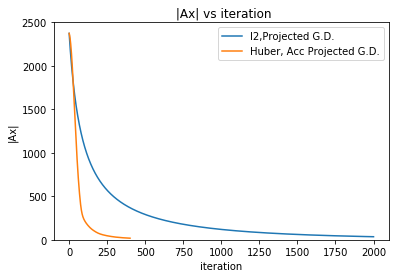

In [96]:
#print(lAccResidue)
lineOri, = plt.plot(lOriResidue,label='l2,Projected G.D.')
#lineHuber, = plt.plot(lHuberResidue,label='Huber,Projected G.D.')
lineAcc, = plt.plot(lAccResidue, label='Huber, Acc Projected G.D.')
plt.title(' |Ax| vs iteration')
plt.ylabel('|Ax|')
plt.xlabel('iteration')
plt.ylim([0,2500])
plt.legend()
plt.show()

In [68]:
# read index 
from scipy.io import loadmat
fMat = '/home/heliu/Dropbox/CO/project/TwoIndex_res10.mat'
mat = loadmat(fMat)
gbcdIndex = mat['gbcd_index']
graphIndex = mat['graph_index']
data_input=np.loadtxt('/home/heliu/Dropbox/CO/project/iter300/energy_v.res')
data_output=np.empty(data_input.shape)
data_output[graphIndex-1]=data_input[gbcdIndex-1]
np.savetxt('/home/heliu/Dropbox/CO/project/161201_GBCD_Tools/gbcd_graph/energy_converted.res',data_output)
# edit input.txt ,input file, misorientation
# ./graph_gbcd
# to MAC
# ./Draw_stereograms 1 energy_converted_gmt_ 5d rainbow  0.32   1.35  0.10

In [97]:
# test on iteration 300 from Adam code
normN = np.loadtxt('/home/heliu/Dropbox/CO/project/AdamM_files-17Jan08/cap_vec.res')
print(normN.shape)
reshapeX = np.hstack([X[:normN.shape[0]],X[normN.shape[0]:2*normN.shape[0]],X[2*normN.shape[0]:]])
print(reshapeX.shape)
energy = np.sum(normN*reshapeX,axis=1)
print(energy.shape)
capVec = np.loadtxt('/home/heliu/Dropbox/CO/project/iter300/cap_vec.res')
energyAdam = np.sum(normN*capVec,axis=1)
print(energyAdam)
print(energy)

(236196, 3)
(236196, 3)
(236196,)
[ 0.75194183  0.64556022  1.1947587  ...,  0.69503057  0.75132625
  0.47892772]
[ 1.156158    0.5485038   1.09560676 ...,  0.65220003  0.66490393
  1.89029944]


In [56]:
print(np.linalg.norm(energyAdam)/np.linalg.norm(energy)*energy)

[ 0.88994349  0.44735356  0.96310891 ...,  0.85545043  1.15115073
  2.46795112]


In [77]:
np.savetxt('accPGD_energy.txt',energy)

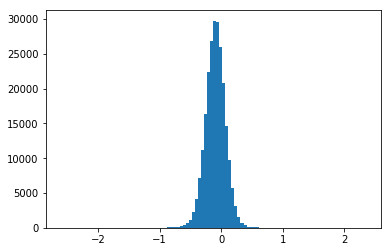

In [79]:
import matplotlib.pyplot as plt
error = energy-energyAdam
plt.hist(error,bins=100)
plt.show()